In [1]:
import random
from copy import deepcopy
from typing import Tuple

import pylab as pl

import numpy as np
import torch
from scipy import stats
from sklearn.metrics import explained_variance_score
from torch import optim, Tensor, nn

from src.agents import Agent
from src.agents.NNAgent import NNAgent
from src.agents.RandomAgent import RandomAgent
from src.envs.two_player_briscola.TwoPlayerBriscola import TwoPlayerBriscola as Briscola
from time import time
import gymnasium as gym
import wandb
from src.utils.AgentPool import AgentPool
from src.utils.training_utils import play_all_moves_of_player, get_state_representation

from src.vectorizers.VectorizedEnv import VectorizedEnv
from src.envs.two_player_briscola.TwoPlayerBriscola import TwoPlayerBriscola

from src.envs.two_player_briscola.BriscolaConstants import Constants

In [16]:
import numpy as np
import random
import pylab as pl

n_groups = 2
grid_size = 20
n_neighbors = 4

person_grid = np.random.randint(0, n_groups, size=(grid_size, grid_size))
person_preferences = np.random.randint(0, 2, size=(grid_size, grid_size, n_neighbors)) * 2 - 1

In [21]:
def get_relation(person_grid: np.array, i: int, j: int, friend_location: int):
    assert 0 <= friend_location <= 3
    n, m = person_grid.shape
    is_friend = False
    if friend_location == 0:
        is_friend = person_grid[i, j] == person_grid[i, (j+1) % m]
    elif friend_location == 1:
        is_friend = person_grid[i, j] == person_grid[(i-1) % n, j]
    elif friend_location == 2:
        is_friend = person_grid[i, j] == person_grid[i, (j-1) % m]
    elif friend_location == 3:
        is_friend = person_grid[i, j] == person_grid[(i+1) % n, j]

    return -1 if is_friend else 1

def get_person_energy(person_grid: np.array, person_preferences: np.array, i: int, j: int):
    energy = 0
    for friend_location in range(n_neighbors):
        energy += person_preferences[i, j, friend_location]*get_relation(person_grid, i, j, friend_location)
        
    return energy

def get_persons_energy(person_grid: np.array, person_preferences: np.array):
    n, m = person_grid.shape
    energy = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            energy[i, j] = get_person_energy(person_grid, person_preferences, i, j)
            
    return energy

def get_energy(person_grid: np.array, person_preferences: np.array):
    return np.sum(get_persons_energy(person_grid, person_preferences))

def plot_person_energy(person_grid: np.array, person_preferences: np.array):
    pl.matshow(get_persons_energy(person_grid, person_preferences), vmin=-n_neighbors, vmax=n_neighbors)
    pl.show()
    
def spin_iteration(person_grid: np.array, person_preferences: np.array):
    n, m = person_grid.shape
    for i in range(n):
        for j in range(m):
            old_value = person_grid[i, j]
            old_energy = get_energy(person_grid, person_preferences)
            person_grid[i, j] = (person_grid[i, j] + 1) % n_groups
            new_energy = get_energy(person_grid, person_preferences)
            
            if new_energy > old_energy:
                person_grid[i, j] = old_value
    
    return person_grid

-702.0


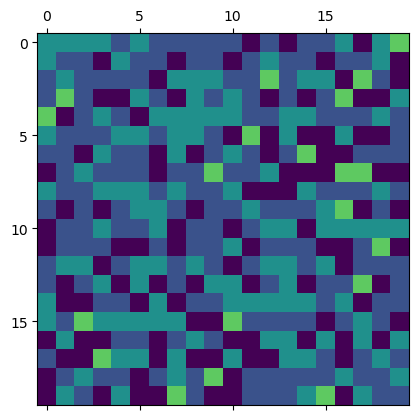

-706.0


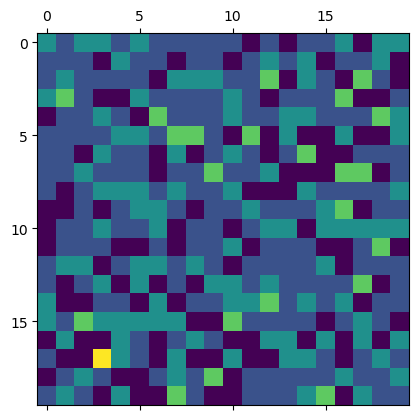

In [23]:
print(get_energy(person_grid, person_preferences))
plot_person_energy(person_grid, person_preferences)
for i in range(10):
    spin_iteration(person_grid, person_preferences)

print(get_energy(person_grid, person_preferences))
plot_person_energy(person_grid, person_preferences)

(array([104.,   0.,   0., 164.,   0.,   0., 113.,   0.,   0.,  19.]),
 array([-4. , -3.4, -2.8, -2.2, -1.6, -1. , -0.4,  0.2,  0.8,  1.4,  2. ]),
 <BarContainer object of 10 artists>)

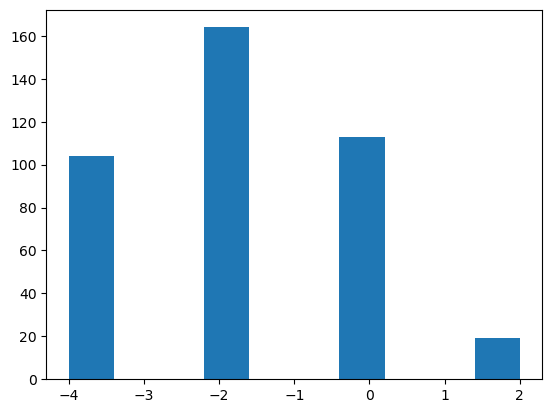

In [20]:
pl.hist(get_persons_energy(person_grid, person_preferences).flatten())

In [2]:
params = {
    "n_envs" : 2048,
    "n_steps": Constants.deck_cards // 2,
    "lr": 3e-3,
    "lr_decay": 0.995,
    "lr_min": 3e-4,
    "mini_batch_size": 1024,
    "total_timesteps": 20_000_000,
    "gamma": 1.,
    "lambda": 0.9,
    "update_epochs": 2,
    "clip_coef": 0.3,
    "normalize_advantage": True,
    "clip_value_loss": True,
    "value_coef": 0.5,
    "entropy_coef": 1e-2,
    "max_grad_norm": 0.5,
    "ratio_win_reward": 0.1,
    "n_opponents": 8,
    "max_pool_size": 128,
    "add_model_every_x_step": 1,
    "nu": 0.1,
    "self_play_opponents": 1,
    "hidden_size": 128,
    "n_layers": 3
}
params["batch_size"] = params["n_envs"] * params["n_steps"]
params["num_updates"] = params["total_timesteps"] // params["batch_size"]

In [3]:
run = wandb.init(
        name="smaller lr decay",
        project="briscolaBot",
        entity="lettera",
        config=params,
        save_code=True,
        sync_tensorboard=False,
        mode="online"
)

wandb: Currently logged in as: lettera. Use `wandb login --relogin` to force relogin


In [23]:
def export_to_onnx(agent: NNAgent, filename="agent.onnx", output_names=None, input_names=None):
    if output_names is None:
        output_names = ["action"]

    if input_names is None:
        input_names = ["input"]

    dummy_input = torch.randn(1, np.prod(agent.observation_shape) + agent.action_size)
    torch.onnx.export(agent, dummy_input, filename, verbose=False, input_names=input_names, output_names=output_names)

In [25]:
agent = NNAgent((162, ), 40, hidden_size=256)
agent.load_state_dict(torch.load("agent.pt"))

export_to_onnx(agent)

torch.Size([1, 162]) torch.Size([1, 40])
tensor([[-1.0150, -0.4085, -0.3272,  0.6845, -0.0116,  0.0833, -0.4302, -0.5566,
         -0.6885,  1.3901,  1.1319,  0.5917, -1.0315,  1.0796, -1.3298, -0.2176,
         -0.9626, -2.0981, -0.8719,  0.7350,  1.3269, -1.5413,  0.2369, -0.4059,
         -0.1600,  2.1844, -0.1539,  2.1859,  0.5690,  1.0467, -1.1876, -1.2035,
          0.1239, -0.4494, -0.1965, -0.4781,  0.1948, -0.5073,  0.6364, -0.9575,
         -1.8515, -2.3515, -0.7917, -3.0825, -1.0261,  0.7789, -1.7436,  1.6456,
         -1.3087,  2.1712, -0.3974,  0.1378, -0.0355,  1.6550,  0.5184, -0.4801,
          1.3318, -0.5009,  0.9421, -0.5971,  0.4015, -1.0337, -0.5593,  0.3144,
         -0.8246, -1.1667,  0.0427,  0.4034, -0.4306,  0.4908,  0.9820,  0.1247,
         -0.2118,  1.0713, -0.6272,  0.0734, -0.6540, -1.4395, -0.5973, -2.1780,
          0.0998,  1.9429, -1.0462, -0.6673,  0.4035,  0.3358,  1.2647, -0.1966,
          0.0652, -2.1604,  0.2765, -0.7375, -0.7879,  0.4022,  1.50

In [28]:
import onnxruntime as ort

ort_session = ort.InferenceSession("agent.onnx")

inputs = np.random.randn(1, 162+40).astype(np.float32)
inputs[:, -40:] = 0
inputs[:, -30] = 1

outputs = ort_session.run(
    ["action"],
    {"input": inputs}
)
print(outputs)

[array([10], dtype=int64)]


In [4]:
from scipy.special import logit


def compute_rating(current_policy: Agent,
                   other_player_policy: Agent,
                   n_games: int = 512,
                   env_fn = lambda: TwoPlayerBriscola(),
                   current_player: str = "player_0",
                   other_player: str = "player_1"):
    vec_env = VectorizedEnv(env_fn, n_games)
    vec_env.reset()
    other_player_policies = [other_player_policy]
    for step in range(params["n_steps"]):
        with torch.no_grad():
            play_all_moves_of_players(vec_env, other_player_policies, other_player)
            next_obs, action_mask, _, _ = get_state_representation(vec_env)
            actions = current_policy.get_actions(next_obs.to(device), action_mask.to(device))

        vec_env.step(actions.cpu().numpy())
    play_all_moves_of_players(vec_env, other_player_policies, "player_1")  # Play the last move

    scores = np.array([env.get_game_outcome(current_player) for env in vec_env.get_envs()], dtype=np.float64)
    mean_score = np.mean(scores)
    return mean_score, logit(mean_score)

In [5]:
vec_env = VectorizedEnv(lambda: TwoPlayerBriscola(), params["n_envs"])

In [6]:
from src.utils.training_utils import play_all_moves_of_players

device = "cpu"
observation_shape = vec_env.single_observation_space()["observation"].shape
action_size = vec_env.single_action_space().n

player_policy = NNAgent(observation_shape, action_size).to(device)

player = vec_env[0].agents[0]
other_player = vec_env[0].agents[1]
pool = AgentPool(params["max_pool_size"], nu=params["nu"])

optimizer = optim.Adam(player_policy.parameters(), lr=params["lr"], eps=1e-5)

obs = torch.zeros((params["n_steps"], params["n_envs"]) + observation_shape).to(device)
actions = torch.zeros((params["n_steps"], params["n_envs"]), dtype=torch.int64).to(device)
actions_masks = torch.zeros((params["n_steps"], params["n_envs"]) + (action_size,), dtype=torch.int64).to(device)
logprobs = torch.zeros((params["n_steps"], params["n_envs"])).to(device)
rewards = torch.zeros((params["n_steps"], params["n_envs"])).to(device)
dones = torch.zeros((params["n_steps"], params["n_envs"]), dtype=torch.int8).to(device)
values = torch.zeros((params["n_steps"], params["n_envs"])).to(device)

global_step = 0
start_time = time()
for update in range(1, params["num_updates"] + 1):
    # Decay lr
    current_lr = optimizer.param_groups[0]["lr"]
    optimizer.param_groups[0]["lr"] = max(params["lr_min"], current_lr*params["lr_decay"])

    # Add agent to pool
    if update % params["add_model_every_x_step"] == 0:
        pool.add_agent(deepcopy(player_policy))

    # Sample agents
    other_player_policies, opponent_indexes = pool.sample_agents(params["n_opponents"] - params["self_play_opponents"])
    other_player_policies += [player_policy] * params["self_play_opponents"]

    # Play episodes
    vec_env.reset()
    play_all_moves_of_players(vec_env, other_player_policies, other_player)
    next_obs, action_mask, reward, next_done = get_state_representation(vec_env)
    for step in range(params["n_steps"]):
        global_step += params["n_envs"]

        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            action, logprob, _, value = player_policy.get_action_and_value(next_obs.to(device), action_mask.to(device))
            values[step] = value.flatten()
        actions[step] = action
        actions_masks[step] = action_mask.to(device)
        logprobs[step] = logprob

        vec_env.step(actions[step].cpu().numpy())
        play_all_moves_of_players(vec_env, other_player_policies, other_player)
        next_obs, action_mask, reward, next_done = get_state_representation(vec_env)
        wins = torch.tensor([env.game_winner() == player for env in vec_env], dtype=torch.float32)
        rewards[step] = (1 - params["ratio_win_reward"]) * reward + (params["ratio_win_reward"] * next_done * wins).to(device)

    # Update rating
    scores = [env.get_game_outcome(other_player) for env in vec_env.get_envs()]
    mean_score_per_opponent = np.empty_like(opponent_indexes, dtype=np.float64)
    for i in range(opponent_indexes.size):
        start, end = (i * len(scores)) // opponent_indexes.size, ((i + 1) * len(scores)) // opponent_indexes.size
        mean_score_per_opponent[i] = np.mean(scores[start:end])

    agent_rating = pool.update_ratings(0., mean_score_per_opponent, opponent_indexes)

    # Bootstrap value
    with torch.no_grad():
        next_value = player_policy.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        last_gae_lambda = 0

        for t in reversed(range(params["n_steps"])):
            if t == params["n_steps"] - 1:
                next_non_terminal = 1. - next_done
                next_values = next_value
            else:
                next_non_terminal = 1. - dones[t+1]
                next_values = values[t+1]

            delta = rewards[t] + params["gamma"] * next_values * next_non_terminal - values[t]
            last_gae_lambda = delta + params["gamma"] * params["lambda"] * next_non_terminal * last_gae_lambda
            advantages[t] = last_gae_lambda

        returns = advantages + values

    # Optimize net
    b_obs = obs.reshape((-1,) + observation_shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape(-1)
    b_action_masks = actions_masks.reshape((-1, action_size))
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    clip_fraction = []
    b_indexes = np.arange(params["batch_size"])
    for epoch in range(params["update_epochs"]):
        np.random.shuffle(b_indexes)
        for start in range(0, params["batch_size"], params["mini_batch_size"]):
            end = start + params["mini_batch_size"]
            mb_indexes = b_indexes[start:end]

            _, newlogprob, entropy, newvalue = player_policy.get_action_and_value(b_obs[mb_indexes], b_action_masks[mb_indexes], b_actions[mb_indexes])
            logratio = newlogprob - b_logprobs[mb_indexes]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl https://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clip_fraction.append(((ratio - 1.0).abs() > params["clip_coef"]).float().mean().item())

            mb_advantages = b_advantages[mb_indexes]
            if params["normalize_advantage"]:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1-params["clip_coef"], 1+params["clip_coef"])
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if params["clip_value_loss"]:
                v_loss_unclipped = (newvalue - b_returns[mb_indexes]) ** 2
                v_clipped = b_values[mb_indexes] + torch.clamp(
                    newvalue - b_values[mb_indexes],
                    -params["clip_coef"],
                    params["clip_coef"],
                )
                v_loss_clipped = (v_clipped - b_returns[mb_indexes]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                value_loss = 0.5 * v_loss_max.mean()
            else:
                value_loss = 0.5 * ((newvalue - b_returns[mb_indexes]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - params["entropy_coef"] * entropy_loss + params["value_coef"] * value_loss

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(player_policy.parameters(), params["max_grad_norm"])
            optimizer.step()

    # Logging
    explained_var = explained_variance_score(b_returns.cpu().numpy(), b_values.cpu().numpy())
    if (update - 1) % 8 == 0:
        outcome_vs_random, rating_vs_random = compute_rating(player_policy, RandomAgent(action_size))

    wandb.log({
        "global_step": global_step,
        "learning_rate": optimizer.param_groups[0]["lr"],
        "value_loss": value_loss.item(),
        "policy_loss": pg_loss.item(),
        "entropy": entropy_loss.item(),
        "total_loss": loss.item(),
        "old_approx_kl": old_approx_kl.item(),
        "approx_kl": approx_kl.item(),
        "clipfrac": np.mean(clip_fraction),
        "explained_variance": explained_var,
        "SPS": int(global_step / (time() - start_time)),
        "reward_per_game": torch.sum(rewards, dim=0).mean(),
        "points_per_game": sum([env.game_state.agent_points[player] for env in vec_env]) / params["n_envs"],
        "ratio_game_won": sum([env.game_winner() == player for env in vec_env]) / params["n_envs"],
        "mean_outcome": sum([env.get_game_outcome(player) for env in vec_env]) / params["n_envs"],
        "outcome_vs_random": outcome_vs_random,
        "rating_vs_random": rating_vs_random,
        "pool_ratings": wandb.Histogram(pool.ratings),
        "pool_entropy": stats.entropy(pool.get_sampling_probability()),
        "pool_std": np.std(pool.ratings),
        "pool_size": len(pool)
    })

C:\Users\loren\Desktop\rl-thesis\src\envs\two_player_briscola\TwoPlayerBriscola.py:162: UserWarning: Tried to execute an illegal action, executing 35 instead
  warn(f"Tried to execute an illegal action, executing {action} instead")
C:\Users\loren\Desktop\rl-thesis\src\envs\two_player_briscola\TwoPlayerBriscola.py:162: UserWarning: Tried to execute an illegal action, executing 35 instead
  warn(f"Tried to execute an illegal action, executing {action} instead")
C:\Users\loren\Desktop\rl-thesis\src\envs\two_player_briscola\TwoPlayerBriscola.py:162: UserWarning: Tried to execute an illegal action, executing 39 instead
  warn(f"Tried to execute an illegal action, executing {action} instead")
C:\Users\loren\Desktop\rl-thesis\src\envs\two_player_briscola\TwoPlayerBriscola.py:162: UserWarning: Tried to execute an illegal action, executing 17 instead
  warn(f"Tried to execute an illegal action, executing {action} instead")
C:\Users\loren\Desktop\rl-thesis\src\envs\two_player_briscola\TwoPlayerB

In [7]:
torch.save(player_policy.state_dict(), 'agent.pt')
# Save as artifact for version control.
artifact = wandb.Artifact('model', type='model')
artifact.add_file('agent.pt')
run.log_artifact(artifact)
wandb.run.finish()

SPS,▁▆▇█▇▅▅▆▆▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅
approx_kl,▆▇█▇▇██▆▆▅▄▅▆▃▃▃▃▃▄▃▄▃▃▂▃▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
clipfrac,▅▇█▇▇▆▇▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
entropy,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
explained_variance,▁███████████████████████████████████████
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
mean_outcome,▁▃▄██▄▇▅▇▅▄▃▂▃▂▂▃▃▃▂▂▂▂▃▂▁▂▂▃▂▂▂▃▁▂▂▂▂▂▂
old_approx_kl,█▅▆█▇▆▇▄▅▅▄▃▄▅▅▃▂▃▄▃▃▄▂▃▃▃▂▂▃▂▂▂▂▃▁▁▂▂▁▁
outcome_vs_random,▁▁▄▅▆▆▆▇▆▇▇▇▇▇▇▇██▇█▇▇▇▇▇▇▇▇▇██▇▇█▇█▇█▇█
points_per_game,▁▄▄██▄▇▅▇▄▄▃▂▃▃▂▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂
